---
# Clustering and Classification using Knowledge Graph Embeddings
---

In this tutorial we will explore how to use the knowledge embeddings generated by a graph of international football matches (since the 19th century) in clustering and classification tasks. Knowledge graph embeddings are typically used for missing link prediction and knowledge discovery, but they can also be used for entity clustering, entity disambiguation, and other downstream tasks. The embeddings are a form of representation learning that allow linear algebra and machine learning to be applied to knowledge graphs, which otherwise would be difficult to do.


We will cover in this tutorial:

1. Creating the knowledge graph (i.e. triples) from a tabular dataset of football matches
2. Training the ComplEx embedding model on those triples
3. Evaluating the quality of the embeddings on a validation set
4. Clustering the embeddings, comparing to the natural clusters formed by the geographical continents
5. Applying the embeddings as features in classification task, to predict match results
6. Evaluating the predictive model on a out-of-time test set, comparing to a simple baseline

We will show that knowledge embedding clusters manage to capture implicit geographical information from the graph and that they can be a useful feature source for a downstream machine learning classification task, significantly increasing accuracy from the baseline.

---

## Requirements

A Python environment with the AmpliGraph library installed. Please follow the [install guide](http://docs.ampligraph.org/en/latest/install.html).

Some sanity check:

In [2]:
!pip install tensorflow==2.9.0
!pip install ampligraph

In [ ]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

## Dataset

We will use the [International football results from 1872 to 2019](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017) available on Kaggle (public domain). It contains over 40 thousand international football matches. Each row contains the following information:
1. Match date
2. Home team name
3. Away team name
4. Home score (goals including extra time)
5. Away score (goals including extra time)
6. Tournament (whether it was a friendly match or part of a tournament)
7. City where match took place
8. Country where match took place
9. Whether match was on neutral grounds

This dataset comes in a tabular format, therefore we will need to construct the knowledge graph ourselves.

In [11]:
from rdflib import Graph, Namespace, URIRef, Literal, RDF

g = Graph()

g.parse('aviation.rdf', format="xml")

RDF = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")
RDFS = Namespace("http://www.w3.org/2000/01/rdf-schema#")
EX = Namespace("http://example.org/war_thunder#")

query1 = """
PREFIX ns1: <http://example.org/war_thunder#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?vehicle ?type ?price ?vehicle_rank ?silverLionBonus
WHERE {
  ?vehicle ns1:hasType ?type ;
           ns1:hasPrice ?price ;
           ns1:hasRank ?vehicle_rank .
  ?vehicle ns1:hasMode ?simulatorMode .
  ?simulatorMode a ns1:simulator ;
                ns1:hasBonuses ?bonuses .
  ?bonuses ns1:silverLionBonus ?silverLionBonus .
  }"""

results1 = g.query(query1)
with open('output.csv', 'w') as file:
    # Заголовки с корректными отступами
    file.write("vehicle\ttype\tprice\tvehicle_rank\tsilverLionBonus\n")
    
    # Данные с удалением префиксов
    for row in results1:
        file.write(
            row[0].replace("http://example.org/war_thunder#", "") + "\t" +
            row[1].replace("http://example.org/war_thunder#", "") + "\t" +
            row[2].replace("http://example.org/war_thunder#", "") + "\t" +
            row[3].replace("http://example.org/war_thunder#", "") + "\t" +
            row[4].replace("http://example.org/war_thunder#", "") + "\n"
        )



In [12]:
df = pd.read_csv("output.csv", sep="\t")

df.isna().sum()
df = df.dropna()

df

,vehicle,type,price,vehicle_rank,silverLionBonus
0,F4F3,Carrier_Fighter,"16,000",2,1.53
1,T3485,Medium_Tank,"155,000",4,1.79
2,M4A1_FL10,Medium_Tank,0,3,3.40
3,T54,Medium_Tank,"340,000",5,2.36
4,Strv_104,Medium_Tank,"450,000",6,2.44
...,...,...,...,...,...
2013,BTR80A,Light_Tank,"270,000",5,2.01
2014,TO55,Medium_Tank,0,5,4.76
2015,BTRZD,SPAAG,"155,000",4,1.96
2016,Do_17_Z7,AA_Fighter,700,1,0.56


The training set will be for vehicles with rank < 4 , while the test set will be >4  

In [13]:
df["train"] = df.vehicle_rank < 4

df.train.value_counts()

train
False    1072
True      937
Name: count, dtype: int64

## Knowledge graph creation
We are going to create a knowledge graph from scratch based on the match information. The idea is that each match is an entity that will be connected to its participating teams, geography, characteristics, and results.

The objective is to generate a new representation of the dataset where each data point is an triple in the form:

    <subject, predicate, object>
    
First we need to create the entities (subjects and objects) that will form the graph. We make sure teams and geographical information result in different entities (e.g. the Brazilian team and the corresponding country will be different).

In [14]:

# Создание уникальных идентификаторов для каждого субъекта и объекта
df["vehicle_id"] = "vehicle" + df.vehicle.str.title().str.replace(" ", "")
df["type_id"] = "type" + df.type.str.title().str.replace(" ", "")
df["price_id"] = "price" + df.price.astype(str)
df["rank_id"] = "rank" + df.vehicle_rank.astype(str)
df["silverLionBonus_id"] = "silverLionBonus" + df.silverLionBonus.astype(str)

# Создание троек вида <subject, predicate, object>
triples = []

for _, row in df.iterrows():
    # Goal information
    type_info = (row["vehicle_id"], "hasVehicle", row["type_id"])
    price_info = (row["vehicle_id"], "hasPrice", row["price_id"])
    rank_info = (row["vehicle_id"], "hasRank", row["rank_id"])
    silverLionBonus_info = (row["vehicle_id"], "hasSilverLionBonus", row["silverLionBonus_id"])

    triples.extend([type_info, price_info, rank_info, silverLionBonus_info])

print(len(triples))

# Преобразование троек в DataFrame
triples_df = pd.DataFrame(triples, columns=['subject', 'predicate', 'object'])

triples_df[(triples_df.subject=="vehicleF4F3")]

8036


,subject,predicate,object
0,vehicleF4F3,hasVehicle,typeCarrier_Fighter
1,vehicleF4F3,hasPrice,"price16,000"
2,vehicleF4F3,hasRank,rank2
3,vehicleF4F3,hasSilverLionBonus,silverLionBonus1.53


Then, we create the actual triples based on the relationship between the entities. We do it only for the triples in the training set (before 2014).

In [15]:
# Предположим, что у нас есть DataFrame `triples_df` с колонками 'subject', 'predicate', 'object'
# Преобразование DataFrame в массив NumPy
triples = triples_df.values

# Проверка, что все элементы в triples являются строками
assert all(isinstance(item, str) for row in triples for item in row), "All elements in triples must be strings"

The whole graph related to this match can be summarised by the triples below:

#### Example output data

<http://ex.com/Team/TeamScotland> ex:isHomeTeamIn Match0.

<http://ex.com/Team/TeamEngland> ex:isAwayTeamIn Match0.
        
<http://ex.com/Match/Match0> ex:inTournament TournamentFriendly.
        
<http://ex.com/Match/Match0> ex:inCity CityGlasgow.

## Training knowledge graph embeddings

We split our training dataset further into training and validation, where the new training set will be used to the knowledge embedding training and the validation set will be used in its evaluation. The test set will be used to evaluate the performance of the classification algorithm built on top of the embeddings.

What differs from the standard method of randomly sampling N points to make up our validation set is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and validation sets by at least one triple.

To accomplish this, AmpliGraph provides the [`train_test_split_no_unseen`](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.train_test_split_no_unseen.html#train-test-split-no-unseen) function.

In [21]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=1000)

print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (7036, 3)
Test set size:  (1000, 3)


In [22]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

model = ScoringBasedEmbeddingModel(k=50,
                                   eta=5,
                                   scoring_type='ComplEx',
                                   seed=0)

# Optimizer, loss and regularizer definition
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

AmpliGraph has implemented [several Knowledge Graph Embedding models](https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html#knowledge-graph-embedding-models) (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the [ComplEx](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.ComplEx.html#ampligraph.latent_features.ComplEx) model, which is known to bring state-of-the-art predictive power.

The hyper-parameter choice was based on the [best results](https://docs.ampligraph.org/en/latest/experiments.html) we have found so far for the ComplEx model applied to some benchmark datasets used in the knowledge graph embeddings community. This tutorial does not cover [hyper-parameter tuning](https://docs.ampligraph.org/en/latest/examples.html#model-selection).

Lets go through the parameters to understand what's going on:

- **`k`**: the dimensionality of the embedding space.
- **`eta`** ($\\eta$) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple.
- **`scoring_type`**: type of model defined by spicific scoring function.
- **`seed`** : random seed, used for reproducibility.
- **`optimizer`** : the Adam optimizer, with a learning rate of 1e-4 set via the *optimizer_params* kwarg.
- **`loss`** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- **`regularizer`** : $L_p$ regularization with $p=3$, i.e. l3 regularization. $\\lambda$ = 1e-5, set via the *regularizer_params* kwarg.

Training should take around 10 minutes on a modern GPU:

In [23]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 10),
          epochs=50, # Number of training epochs
          verbose=True # Displays a progress bar.
          )

Epoch 1/50
12/12 [==============================] - 1s 119ms/step - loss: 1146.0726
Epoch 2/50
12/12 [==============================] - 0s 7ms/step - loss: 1146.0337
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 1145.9961
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 1145.9624
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 1145.9290
Epoch 6/50
12/12 [==============================] - 0s 7ms/step - loss: 1145.8949
Epoch 7/50
12/12 [==============================] - 0s 7ms/step - loss: 1145.8615
Epoch 8/50
12/12 [==============================] - 0s 7ms/step - loss: 1145.8278
Epoch 9/50
12/12 [==============================] - 0s 7ms/step - loss: 1145.7927
Epoch 10/50
12/12 [==============================] - 0s 7ms/step - loss: 1145.7574
Epoch 11/50
12/12 [==============================] - 0s 6ms/step - loss: 1145.7216
Epoch 12/50
12/12 [==============================] - 0s 7ms/step - loss: 1145.6853
Epoch 13/50

## Evaluating knowledge embeddings

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions.

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no negative statements generated by the corruption procedure are actually positives. This is simply can be done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.

For this we'll use method `evaluate` of model object:

- **`X_valid`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`use_filter`** - will filter out the false negatives generated by the corruption strategy.
- **`corrupt_side`** - specifies approach for triple corruption. 's,o' option means t True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - displays a progress bar.

In [24]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

101/101 [==============================] - 2s 17ms/step


We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions.

- **mrr_score**: The function computes the mean of the reciprocal of elements of a vector of rankings ranks.
- **hits_at_n_score**: The function computes how many elements of a vector of rankings ranks make it to the top n positions.

In [25]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

# Преобразование массива рангов в одномерный массив
flat_ranks = ranks.flatten()
# Фильтрация одномерного массива, чтобы оставить только положительные значения (начиная с 1)
res_ranks = flat_ranks[flat_ranks > 0]

mr = mr_score(res_ranks)
mrr = mrr_score(res_ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(res_ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(res_ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(res_ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.07
MR: 748.97
Hits@10: 0.11
Hits@3: 0.07
Hits@1: 0.04


We can interpret these results by stating that the model will rank the correct entity within the top-3 possibilities 34% of the time.

By themselves, these metrics are not enough to conclude the usefulness of the embeddings in a downstream task, but they suggest that the embeddings have learned a reasonable representation enough to consider using them in more tasks.

## Clustering and embedding visualization

To evaluate the subjective quality of the embeddings, we can visualise the embeddings on 2D space and also cluster them on the original space. We can compare the clustered embeddings with natural clusters, in this case the continent where the team is from, so that we have a ground truth to evaluate the clustering quality both qualitatively and quantitatively.

Requirements:

* seaborn
* adjustText
* incf.countryutils

For seaborn and adjustText, simply install them with `pip install seaborn adjustText`.

For incf.countryutils, do the following steps:
```bash
git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
cd incf.countryutils
pip install .```

In [26]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

"git" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
���⥬� �� 㤠���� ���� 㪠����� ����.


In [27]:
!pip install adjustText

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

We create a map from the team ID (e.g. "TeamBrazil") to the team name (e.g. "Brazil") for visualization purposes.

In [30]:
id_to_name_map = {**dict(zip(df.vehicle_id, df.vehicle)),
                  **dict(zip(df.type_id, df.type))}
vehicle_to_silverLionBonus_map = {**dict(zip(df.vehicle_id, df.silverLionBonus))}

print(vehicle_to_silverLionBonus_map)

{'vehicleF4F3': 1.53, 'vehicleT3485': 1.79, 'vehicleM4A1_Fl10': 3.4, 'vehicleT54': 2.36, 'vehicleStrv_104': 2.44, 'vehicleOf40': 2.36, 'vehicleLvrbv_701': 2.35, 'vehiclePby5_Catalina': 0.8, 'vehicleSuper_Etendard': 6.0, 'vehicleMig23Mld': 6.0, 'vehicleIndependent': 1.24, 'vehicleStug_Iii_G': 1.52, 'vehicleType_62': 1.95, 'vehiclePzii%C2%A0F': 0.3, 'vehicleConcept_3': 1.08, 'vehiclePziii%C2%A0E': 0.11, 'vehicleIs2': 1.93, 'vehicleBf_110_G2': 2.15, 'vehicleLeopard_2_Pzbtl_123': 4.84, 'vehicleT26E5': 1.95, 'vehicleF14A_Iriaf': 4.95, 'vehicleLancaster_Mr7': 5.09, 'vehiclePhng_Khng_T34': 4.36, 'vehicleJaguar_E': 6.0, 'vehicleT62': 2.44, 'vehicleTcm20': 2.1, 'vehicleKw_I_C_756_R': 3.41, 'vehicleZtz96': 2.37, 'vehicleJ7E': 6.0, 'vehicleSb_2M105': 1.03, 'vehicleMig21Bissau': 6.0, 'vehicleOb%27Ekt_279': 2.5, 'vehicleLeopard_1A5': 2.38, 'vehicleType_90_B': 2.17, 'vehicleSo4050_Vautour_Iin': 12.0, 'vehicleTornado_Ids_1995': 6.0, 'vehicleM60': 2.36, 'vehicleT3457_1943': 3.14, 'vehicleMig21S_R13300

We now create a dictionary with the embeddings of all teams:

In [31]:
entities = df.vehicle_id[df["train"]].unique()
entity_embeddings = dict(zip(entities, model.get_embeddings(entities)))
entities

array(['vehicleF4F3', 'vehicleM4A1_Fl10', 'vehiclePby5_Catalina',
       'vehicleIndependent', 'vehicleStug_Iii_G', 'vehiclePzii%C2%A0F',
       'vehicleConcept_3', 'vehiclePziii%C2%A0E', 'vehicleBf_110_G2',
       'vehiclePhng_Khng_T34', 'vehicleKw_I_C_756_R', 'vehicleSb_2M105',
       'vehicleT3457_1943', 'vehicleM3_Lee', 'vehicleI153M62_Zhukovskogo',
       'vehicleJag10_29K', 'vehicleAmx13_Fl11',
       'vehicleSturmpanzer%C2%A0Ii', 'vehicleSdkfz222', 'vehicleStuart_I',
       'vehicleZut37', 'vehicleStug%C2%A0Iii%C2%A0A', 'vehicleChiha_Lg',
       'vehicleNato', 'vehicleV11', 'vehicleJ5N1', 'vehicleMig334',
       'vehicleChurchill_Avre_Petard', 'vehiclePe283', 'vehiclePe2205',
       'vehicleDicker%C2%A0Max', 'vehicleTandem_Mai', 'vehicleB10B',
       'vehiclePziv%C2%A0F1', 'vehicleSmk', 'vehicleBt5',
       'vehicleMatilda_Iii', 'vehicleBoston_Mki', 'vehicleM4A3_76_W',
       'vehiclePvlvv_Fm42', 'vehicleEr2_M105R_Lu',
       'vehicleWhirlwind_Mk_I', 'vehicleBv_138_C1',
       '

We use PCA to project the embeddings from the 200 space into 2D space:

In [34]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in entity_embeddings.values()]))

We will cluster the teams embeddings on its original 200-dimensional space using the `find_clusters` in our discovery API:

In [35]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(entities, model, clustering_algorithm, mode='e')

This helper function uses the `incf.countryutils` library to translate country names to their corresponding continents.

In [40]:
plot_df = pd.DataFrame({"entities": entities,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "silverLionBonus": pd.Series(entities).map(film_to_rating_map),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})
plot_df

,entities,embedding1,embedding2,silverLionBonus,cluster
0,vehicleF4F3,-0.071491,-0.073191,1.53,cluster1
1,vehicleM4A1_Fl10,0.095717,0.033558,3.40,cluster3
2,vehiclePby5_Catalina,-0.113091,-0.021076,0.80,cluster0
3,vehicleIndependent,0.046620,-0.030788,1.24,cluster5
4,vehicleStug_Iii_G,0.051043,-0.055094,1.52,cluster3
...,...,...,...,...,...
763,vehicleJagdpanzer%C2%A0Iv,0.120331,-0.007155,1.35,cluster3
764,vehicleIkv_73,0.048865,0.105287,1.82,cluster4
765,vehicleStrv_M42_Dt,0.050749,-0.043326,1.40,cluster5
766,vehicleArcher,0.029235,-0.018424,0.58,cluster1


This dataframe contains for each team their projected embeddings to 2D space via PCA, their continent and the KMeans cluster. This will be used alongisde Seaborn to make the visualizations.

In [41]:
def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if np.random.random() < 0.05:  # Подписываем случайные точки
            texts.append(plt.text(point['embedding1'] + 0.02, point['embedding2'] + 0.01, str(point["entities"])))
    adjust_text(texts)

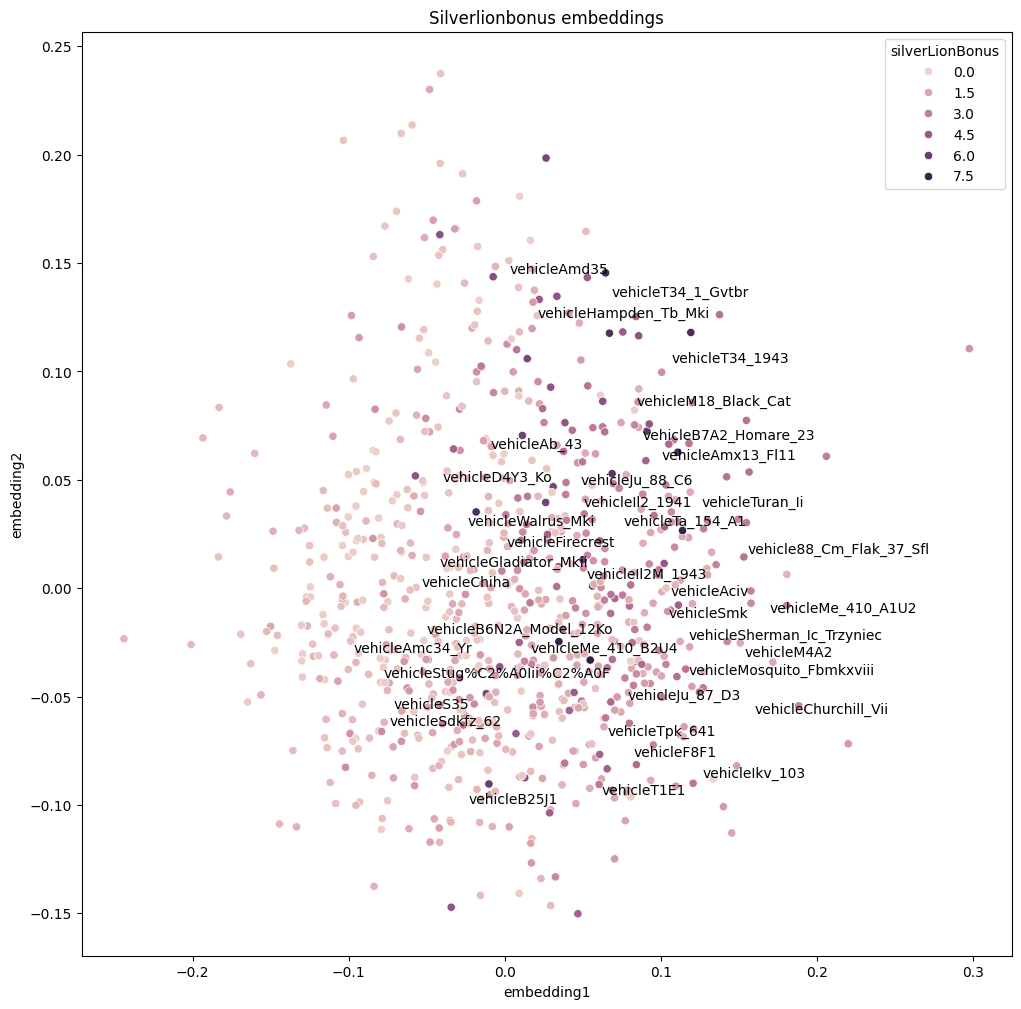

In [42]:
plot_clusters("silverLionBonus")

We plot the results on a 2D scatter plot, coloring the teams by the continent or cluster and also displaying some individual team names.

We always display the names of the top 20 teams (according to [FIFA rankings](https://en.wikipedia.org/wiki/FIFA_World_Rankings)) and a random subset of the rest.

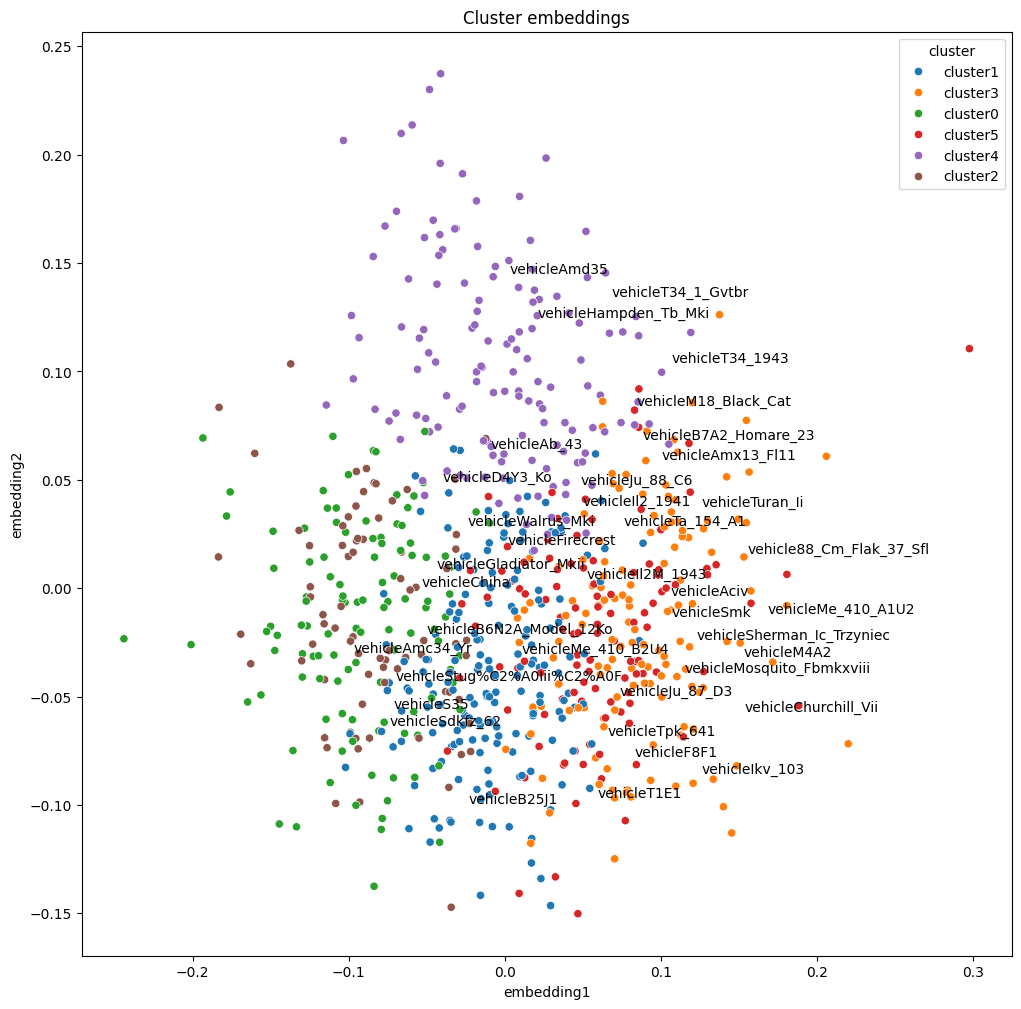

In [43]:
plot_clusters("cluster")

We can see that K-Means found very similar cluster to the natural geographical clusters by the continents. This shows that on the 200-dimensional embedding space, similar teams appear close together, which can be captured by a clustering algorithm.

Our evaluation of the clusters can be more objective by using a metric such as the [adjusted Rand score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html), which varies from -1 to 1, where 0 is random labelling and 1 is a perfect match:

In [45]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.silverLionBonus, plot_df.cluster)

c:\Users\loman\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


0.0256014968562946

## Classification

We will use the knowledge embeddings to predict future matches as a classification problem.

We can model it as a multiclass problem with three classes: home team wins, home team loses, draw.

The embeddings are used directly as features to a XGBoost classifier.

First we need to determine the target:

In [51]:
df.silverLionBonus


0       1.53
1       1.79
2       3.40
3       2.36
4       2.44
        ... 
2013    2.01
2014    4.76
2015    1.96
2016    0.56
2017    6.00
Name: silverLionBonus, Length: 2009, dtype: float64

In [49]:
df["results"] = (df.rating == 7.6).astype(int) + \
                (df.rating == 7.7).astype(int)*2 + \
                (df.rating == 7.8).astype(int)*3 + \
                (df.rating == 7.9).astype(int)*4 + \
                (df.rating == 8.0).astype(int)*5 + \
                (df.rating == 8.1).astype(int)*6 + \
                (df.rating == 8.2).astype(int)*7 + \
                (df.rating == 8.3).astype(int)*8 + \
                (df.rating == 8.4).astype(int)*9 + \
                (df.rating == 8.5).astype(int)*10 + \
                (df.rating == 8.6).astype(int)*11 + \
                (df.rating == 8.7).astype(int)*12 + \
                (df.rating == 8.8).astype(int)*13 + \
                (df.rating == 8.9).astype(int)*14 + \
                (df.rating == 9.).astype(int)*15 + \
                (df.rating == 9.1).astype(int)*16 + \
                (df.rating == 9.2).astype(int)*17 + \
                (df.rating == 9.3).astype(int)*18 + \
                 - 1
df.rating.value_counts(normalize=True)

AttributeError: 'DataFrame' object has no attribute 'rating'

In [ ]:
df.results.value_counts(normalize=True)

,proportion
results,
1,0.175666
2,0.135889
3,0.120500
4,0.114921
5,0.113661
0,0.091253
6,0.088733
7,0.075594
8,0.030508


### Original dataset

First install xgboost with `pip install xgboost`.

In [ ]:
!pip install xgboost

In [ ]:
new_df = df[["results", "rating", "train"]].copy()
new_df

,results,rating,train
0,2,7.8,True
1,2,7.8,True
2,2,7.8,True
3,2,7.8,True
4,2,7.8,True
...,...,...,...
11111,0,7.6,True
11112,0,7.6,True
11113,0,7.6,True
11114,0,7.6,True


In [ ]:
encoded_cols = pd.get_dummies(df[["film", "rating", "duration", "director"]])
df

,film,category,director,actor,duration,release_year,rating,train,film_id,category_id,director_id,actor_id,duration_id,release_year_id,rating_id,results
0,Once,Drama,JohnCarney,GlenHansard,86,2007,7.8,True,FilmOnce,CategoryDrama,DirectorJohncarney,ActorGlenhansard,Duration86,ReleaseYear2007,Rating7.8,2
1,Once,Music,JohnCarney,GlenHansard,86,2007,7.8,True,FilmOnce,CategoryMusic,DirectorJohncarney,ActorGlenhansard,Duration86,ReleaseYear2007,Rating7.8,2
2,Once,Romance,JohnCarney,GlenHansard,86,2007,7.8,True,FilmOnce,CategoryRomance,DirectorJohncarney,ActorGlenhansard,Duration86,ReleaseYear2007,Rating7.8,2
3,Once,Drama,JohnCarney,MarkétaIrglová,86,2007,7.8,True,FilmOnce,CategoryDrama,DirectorJohncarney,ActorMarkétairglová,Duration86,ReleaseYear2007,Rating7.8,2
4,Once,Music,JohnCarney,MarkétaIrglová,86,2007,7.8,True,FilmOnce,CategoryMusic,DirectorJohncarney,ActorMarkétairglová,Duration86,ReleaseYear2007,Rating7.8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11111,The_Invisible_Man,Sci-Fi,JamesWhale,GloriaStuart,71,1933,7.6,True,FilmThe_Invisible_Man,CategorySci-Fi,DirectorJameswhale,ActorGloriastuart,Duration71,ReleaseYear1933,Rating7.6,0
11112,The_Invisible_Man,Horror,JamesWhale,WilliamHarrigan,71,1933,7.6,True,FilmThe_Invisible_Man,CategoryHorror,DirectorJameswhale,ActorWilliamharrigan,Duration71,ReleaseYear1933,Rating7.6,0
11113,The_Invisible_Man,Sci-Fi,JamesWhale,WilliamHarrigan,71,1933,7.6,True,FilmThe_Invisible_Man,CategorySci-Fi,DirectorJameswhale,ActorWilliamharrigan,Duration71,ReleaseYear1933,Rating7.6,0
11114,The_Invisible_Man,Horror,JamesWhale,HenryTravers,71,1933,7.6,True,FilmThe_Invisible_Man,CategoryHorror,DirectorJameswhale,ActorHenrytravers,Duration71,ReleaseYear1933,Rating7.6,0


Split date:

In [ ]:
new_df = new_df.join(encoded_cols, lsuffix='_left')

Create a multiclass model:

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [ ]:
X_train = new_df[df["train"]].drop(["results"], axis=1)
y_train = new_df[df["train"]].results
X_val = new_df[~df["train"]].drop(["results"], axis=1)
y_val = new_df[~df["train"]].results

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
X_train

,rating_left,train,rating,duration,film_(500)_Days_of_Summer,film_127_Hours,film_12_Angry_Men,film_12_Years_a_Slave,film_1917,film_2001:_A_Space_Odyssey,...,director_YilmazErdogan,director_YimouZhang,director_YoshiakiKawajiri,director_YoshifumiKondô,director_YôjirôTakita,director_ZackSnyder,director_ZazaUrushadze,director_ZoyaAkhtar,director_ÖmerFarukSorak,director_ÖmerVargi
0,7.8,True,7.8,86,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,7.8,True,7.8,86,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,7.8,True,7.8,86,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,7.8,True,7.8,86,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7.8,True,7.8,86,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11111,7.6,True,7.6,71,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11112,7.6,True,7.6,71,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11113,7.6,True,7.6,71,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11114,7.6,True,7.6,71,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
clf_model.fit(X_train, y_train, verbose=1)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
clf_model.fit(clf_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Result

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_val, clf_model.predict(X_val))

0.5283765078109551

### Graph embedings

Now we create a function that extracts the features (knowledge embeddings for home and away teams) and the target for a particular subset of the dataset:

In [ ]:
def get_features_target(mask):

    def get_embeddings(team):
        return team_embeddings.get(team, np.full(200, np.nan))

    X = np.hstack((np.vstack(df[mask].home_team_id.apply(get_embeddings).values),
                   np.vstack(df[mask].away_team_id.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

In [ ]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

In [ ]:
clf_X_train.shape, clf_X_test.shape

((35714, 400), (5057, 400))

Note that we have 200 features by team because the ComplEx model uses imaginary and real number for its embeddings, so we have twice as many parameters as defined by `k=100` in its model definition.

We also have some missing information from the embeddings of the entities (i.e. teams) that only appear in the test set, which are unlikely to be correctly classified:

In [ ]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

105.0

Create a multiclass model with 500 estimators:

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

Fit the model using all of the training samples:

In [ ]:
clf_model.fit(clf_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

The baseline accuracy for this problem is 47%, as that is the frequency of the most frequent class (home team wins):

In [ ]:
df[~df["train"]].results.value_counts(normalize=True)

results
0    0.471030
2    0.287325
1    0.241645
Name: proportion, dtype: float64

In [ ]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.527783270713862

In conclusion, while the baseline for this classification problem was 47%, with just the knowledge embeddings alone we were able to build a classifier that achieves **53%** accuracy.

As future work, we could add more features to the model (not embeddings related) and tune the model hyper-parameters.

## Link prediction

Link prediction allows us to infer missing links in a graph.

In our case, we're going to predict match result.
Choose match that exist in train dataset.

In [ ]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

In [ ]:
df = pd.DataFrame(X_train,columns = ['subject','predicate','object'])
matchSubject = "Match1324"
print(df[df.subject==matchSubject])

          subject     predicate              object
102407  Match1324    awayScores                   1
116179  Match1324     inCountry       CountryBrazil
126093  Match1324    homeScores                   4
158124  Match1324  inTournament  TournamentFriendly
172564  Match1324        inCity    CityRioDeJaneiro
266651  Match1324     isNeutral               False


Remove result for this match from train dataframe.

In [ ]:
dfFiltered = np.array(df[(df.subject!=matchSubject) | ((df.subject==matchSubject) & ~df.predicate.isin(["homeScores","awayScores"]))])

Fit model on triples without results for current match.

In [ ]:
model.fit(dfFiltered)

Epoch 1/100
384/384 [==============================] - 41s 108ms/step - loss: 5672.3242
Epoch 2/100
384/384 [==============================] - 41s 106ms/step - loss: 5542.9214
Epoch 3/100
384/384 [==============================] - 41s 106ms/step - loss: 5419.5327
Epoch 4/100
384/384 [==============================] - 42s 111ms/step - loss: 5301.7891
Epoch 5/100
384/384 [==============================] - 42s 111ms/step - loss: 5189.2979
Epoch 6/100
384/384 [==============================] - 41s 108ms/step - loss: 5081.7212
Epoch 7/100
384/384 [==============================] - 41s 106ms/step - loss: 4978.7417
Epoch 8/100
384/384 [==============================] - 41s 107ms/step - loss: 4880.0381
Epoch 9/100
384/384 [==============================] - 41s 106ms/step - loss: 4785.3955
Epoch 10/100
384/384 [==============================] - 41s 106ms/step - loss: 4694.5400
Epoch 11/100
384/384 [==============================] - 41s 107ms/step - loss: 4607.2554
Epoch 12/100
384/384 [========

We can create a few statements for this match result.

In [ ]:
statements = np.array([
    [f'{matchSubject}', 'homeScores', '0'],
    [f'{matchSubject}', 'homeScores', '1'],
    [f'{matchSubject}', 'homeScores', '2'],
    [f'{matchSubject}', 'homeScores', '3'],
    [f'{matchSubject}', 'homeScores', '4'],
    [f'{matchSubject}', 'awayScores', '0'],
    [f'{matchSubject}', 'awayScores', '1'],
    [f'{matchSubject}', 'awayScores', '2'],
    [f'{matchSubject}', 'awayScores', '3'],
    [f'{matchSubject}', 'awayScores', '4']
])

Unite the triplets of the graph and the proposed statements.

In [ ]:
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
statements_filter

array([['Match33087', 'isNeutral', 'False'],
       ['TeamWales', 'isAwayTeamIn', 'Match5782'],
       ['Match5992', 'awayScores', '5'],
       ...,
       ['Match14640', 'inCountry', 'CountryChad'],
       ['Match21824', 'isNeutral', 'False'],
       ['Match11653', 'homeScores', '1']], dtype='<U48')

In [ ]:
ranks = model.evaluate(statements,
                      use_filter={'train': dfFiltered,
                                  'test': statements},
                      corrupt_side='s,o',
                      verbose=True)

NameError: name 'model' is not defined

In [ ]:
raiting = model.predict(statements)
raiting

array([-0.5846524 ,  0.08066474, -0.48785803,  1.5089438 ,  5.684367  ,
       -0.4420216 ,  2.5865698 ,  2.0160317 ,  1.2500255 , -0.39739496],
      dtype=float32)

Present the result of predictions.

In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in statements],
                      ranks,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'raiting', 'prob']).sort_values("prob")

,statement,rank,score,prob
0,Match1324 homeScores 0,"[24323, 37191]",-0.584652,0.357863
2,Match1324 homeScores 2,"[25271, 36315]",-0.487858,0.380398
5,Match1324 awayScores 0,"[18691, 33323]",-0.442022,0.391259
9,Match1324 awayScores 4,"[32198, 31962]",-0.397395,0.401938
1,Match1324 homeScores 1,"[20895, 10848]",0.080665,0.520155
8,Match1324 awayScores 3,"[23953, 86]",1.250026,0.777304
3,Match1324 homeScores 3,"[22831, 67]",1.508944,0.818905
7,Match1324 awayScores 2,"[17498, 22]",2.016032,0.882470
6,Match1324 awayScores 1,"[12518, 6]",2.586570,0.929992
4,Match1324 homeScores 4,"[16943, 1]",5.684367,0.996613
